In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, csc_matrix

# Loading the data and preprocessing it

In [2]:
movies = pd.read_csv('ml-1m/ml-1m/movies.dat', sep='::', header=None, engine='python', encoding='ISO-8859-1', names=['MovieID', 'Title', 'Genres'])
ratings = pd.read_csv('ml-1m/ml-1m/ratings.dat', sep='::', header=None, engine='python', encoding='ISO-8859-1', names=['UserID', 'MovieID', 'Rating', 'Timestamp'])
users = pd.read_csv('ml-1m/ml-1m/users.dat', sep='::', header=None, engine='python', encoding='ISO-8859-1', names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])

# Rebase IDs to be contiguous integers 0...N-1 (useful for matrix indexing)
user2idx = {old: new for new, old in enumerate(users['UserID'].unique())}
movie2idx = {old: new for new, old in enumerate(movies['MovieID'].unique())}

users['UserID'] = users['UserID'].map(user2idx)
movies['MovieID'] = movies['MovieID'].map(movie2idx)
ratings['UserID'] = ratings['UserID'].map(user2idx)
ratings['MovieID'] = ratings['MovieID'].map(movie2idx)

print('Movies shape:', movies.shape)
print(movies.head())
print('\n')

movies['Genres'] = movies['Genres'].str.split('|').apply(lambda x: set(x))
genres_set = set().union(*movies['Genres'])

print('Ratings shape:', ratings.shape)
print(ratings.head())
print('\n')

print('Users shape:', users.shape)
print(users.head())
print('\n')

print('Genres:', genres_set)

Movies shape: (3883, 3)
   MovieID                               Title                        Genres
0        0                    Toy Story (1995)   Animation|Children's|Comedy
1        1                      Jumanji (1995)  Adventure|Children's|Fantasy
2        2             Grumpier Old Men (1995)                Comedy|Romance
3        3            Waiting to Exhale (1995)                  Comedy|Drama
4        4  Father of the Bride Part II (1995)                        Comedy


Ratings shape: (1000209, 4)
   UserID  MovieID  Rating  Timestamp
0       0     1176       5  978300760
1       0      655       3  978302109
2       0      902       3  978301968
3       0     3339       4  978300275
4       0     2286       5  978824291


Users shape: (6040, 5)
   UserID Gender  Age  Occupation Zip-code
0       0      F    1          10    48067
1       1      M   56          16    70072
2       2      M   25          15    55117
3       3      M   45           7    02460
4       4      M

In [3]:
ratings = pd.read_csv("df_merged.csv")

We turn rating into binary variables

In [4]:
ratings['binary_rating'] = ratings['Rating'].apply(lambda x: 1 if x >= 4 else 0)
ratings["Timestamp"] = pd.to_datetime(ratings["Timestamp"], unit='s')
ratings.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,binary_rating
0,1,Toy Story,"['Animation', ""Children's"", 'Comedy']",1995,1,5,2001-01-06 23:37:48,1
1,1,Toy Story,"['Animation', ""Children's"", 'Comedy']",1995,6,4,2000-12-31 04:30:08,1
2,1,Toy Story,"['Animation', ""Children's"", 'Comedy']",1995,8,4,2000-12-31 03:31:36,1
3,1,Toy Story,"['Animation', ""Children's"", 'Comedy']",1995,9,5,2000-12-31 01:25:52,1
4,1,Toy Story,"['Animation', ""Children's"", 'Comedy']",1995,10,5,2000-12-31 01:34:34,1


In [5]:
# Create a set of triplets (UserID, MovieID, binary_rating)
ratings_triplets = set(zip(ratings['UserID'], ratings['MovieID'], ratings['binary_rating']))

# Verify the result
print(f'Number of unique triplets: {len(ratings_triplets)}')
list(ratings_triplets)[:5]

Number of unique triplets: 1000209


[(1032, 1210, 1),
 (5008, 1097, 1),
 (1125, 2391, 1),
 (1357, 2651, 1),
 (3411, 1518, 0)]

# Creating the KNN bandit class

In [6]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, csc_matrix

class KNNBandit:
    def __init__(self, k, ratings, alpha_prior=1.0, beta_prior=100.0):
        """
        Initializes the Bandit using both Full Ratings (for score) and Binary Ratings (for reward).
        
        Args:
            k (int): Number of neighbors to consult.
            ratings (pd.DataFrame): Dataframe must contain:
                                    - 'UserID', 'MovieID'
                                    - 'Rating' (scale 1-5, for prediction)
                                    - 'binary_rating' (0 or 1, for reward/update)
            alpha_prior (float): Initial alpha (successes).
            beta_prior (float): Initial beta (failures).
        """
        self.k = k
        self.alpha_prior = alpha_prior
        self.beta_prior = beta_prior
        
        # --- 1. ID MAPPING ---
        self.user_ids = ratings['UserID'].unique()
        self.item_ids = ratings['MovieID'].unique()
        
        self.user_map = {uid: i for i, uid in enumerate(self.user_ids)}
        self.item_map = {iid: i for i, iid in enumerate(self.item_ids)}
        
        self.rev_user_map = {i: uid for uid, i in self.user_map.items()}
        self.rev_item_map = {i: iid for iid, i in self.item_map.items()}
        
        self.n_users = len(self.user_ids)
        self.n_items = len(self.item_ids)
        
        # --- 2. GROUND TRUTH MATRICES ---
        rows = [self.user_map[u] for u in ratings['UserID']]
        cols = [self.item_map[i] for i in ratings['MovieID']]
        
        # A. RATING MATRIX (1.0 - 5.0)
        # Used for Scikit/Prediction: Neighbors contribute 5.0 for best movies, 1.0 for worst.
        # Since all ratings are > 0, the sparsity structure here strictly represents "Seen movies".
        data_rating = ratings['Rating'].values.astype(np.float32)
        self.R_csr_rating = csr_matrix((data_rating, (rows, cols)), shape=(self.n_users, self.n_items))
        
        # B. BINARY MATRIX (0.0 or 1.0)
        # Used for Reward & Updates: Defines "Success" and "Agreement".
        data_binary = ratings['binary_rating'].values.astype(np.float32)
        self.R_csr_binary = csr_matrix((data_binary, (rows, cols)), shape=(self.n_users, self.n_items))
        self.R_csc_binary = csc_matrix((data_binary, (rows, cols)), shape=(self.n_users, self.n_items))
        
        # --- 3. INITIALIZE BANDIT PARAMETERS ---
        self.alpha = np.full((self.n_users, self.n_users), alpha_prior, dtype=np.float32)
        self.n = np.full(self.n_users, alpha_prior + beta_prior, dtype=np.float32)
        
        # --- 4. HISTORY TRACKING ---
        self.seen_mask = [set() for _ in range(self.n_users)]

    def simulate(self, n_interactions, max_attempts=None):
        """
        Runs the simulation. 
        - Picks items based on weighted 'Rating' (1-5).
        - Rewards based on 'binary_rating' (0/1).
        """
        list_of_recommendations = []
        
        if max_attempts is None:
            max_attempts = n_interactions * 50
            
        print(f"Starting simulation for {n_interactions} valid interactions...")
        
        total_attempts = 0
        
        while len(list_of_recommendations) < n_interactions and total_attempts < max_attempts:
            total_attempts += 1
            
            # 1. Pick a random target user
            u_idx = np.random.randint(self.n_users)
            
            # ==========================================================
            # PHASE 1: PREDICTION (Using 1-5 Ratings)
            # ==========================================================
            
            # Thompson Sampling to pick reliable neighbors
            beta_params = self.n - self.alpha[u_idx]
            p = np.random.beta(self.alpha[u_idx], beta_params)
            p[u_idx] = -1.0 
            
            top_k_indices = np.argpartition(p, -self.k)[-self.k:]
            
            neighbor_weights = p[top_k_indices]
            
            # KEY CHANGE: We access R_csr_rating here.
            # The matrix contains 1-5 values. 
            # Weighted Sum = (Trust * 5.0) vs (Trust * 1.0).
            # This naturally pushes the score higher for movies neighbors gave 5 stars to.
            neighbor_ratings = self.R_csr_rating[top_k_indices] 
            
            scores = neighbor_weights @ neighbor_ratings
            
            if self.seen_mask[u_idx]:
                scores[list(self.seen_mask[u_idx])] = -np.inf
                
            if scores.max() == -np.inf:
                continue
                
            if scores.max() <= 0:
                 rec_item_idx = np.random.randint(self.n_items)
            else:
                rec_item_idx = np.argmax(scores)
            
            # ==========================================================
            # PHASE 2: ORACLE (Check Existence via Rating Matrix)
            # ==========================================================
            
            # We use R_csr_rating indices to check "Seen" status because 
            # 1-5 ratings are never 0, guaranteeing the sparse structure holds valid history.
            start_ptr = self.R_csr_rating.indptr[u_idx]
            end_ptr = self.R_csr_rating.indptr[u_idx + 1]
            user_history_indices = self.R_csr_rating.indices[start_ptr:end_ptr]
            
            self.seen_mask[u_idx].add(rec_item_idx)
            
            if rec_item_idx not in user_history_indices:
                continue # User never saw this movie -> Skip
                
            # ==========================================================
            # PHASE 3: REWARD (Using Binary Matrix)
            # ==========================================================
            
            # Retrieve the Binary Reward (0 or 1) provided by the dataframe
            # Since we confirmed existence above, getting 0 here implies "Dislike", not "Missing".
            reward = self.R_csr_binary[u_idx, rec_item_idx]
            
            # Retrieve the Full Rating for reporting (optional)
            real_rating_val = self.R_csr_rating[u_idx, rec_item_idx]
            
            real_user_id = self.rev_user_map[u_idx]
            real_item_id = self.rev_item_map[rec_item_idx]
            
            # Store recommendation
            list_of_recommendations.append([real_user_id, real_item_id, real_rating_val, reward])
            
            # Increment evidence count
            self.n[u_idx] += 1
            
            if reward == 1:
                # CASE: SUCCESS
                # Update alpha for neighbors who AGREED (also had binary_rating == 1)
                
                # We look at the Binary Column Matrix
                item_col_start = self.R_csc_binary.indptr[rec_item_idx]
                item_col_end = self.R_csc_binary.indptr[rec_item_idx + 1]
                
                users_rated_indices = self.R_csc_binary.indices[item_col_start:item_col_end]
                users_rated_values = self.R_csc_binary.data[item_col_start:item_col_end]
                
                # Filter: Keep only users who Liked (value == 1)
                # Note: Sparse matrix data usually doesn't store explicit 0s, 
                # but if it did, this filter handles it.
                users_who_liked = users_rated_indices[users_rated_values == 1]
                
                self.alpha[users_who_liked, u_idx] += 1
                self.alpha[u_idx, users_who_liked] += 1
                
        print(f"Simulation finished. Collected {len(list_of_recommendations)} valid interactions.")
        return list_of_recommendations

In [7]:
# Initialize the bandit
knn_bandit = KNNBandit(k=10, ratings=ratings)

# Run simulation
print("Starting simulation...")
recommendations = knn_bandit.simulate(n_interactions=3*10**4)
print(f"Simulation finished. Recommendation list: {recommendations}")
print(len(recommendations))

Starting simulation...
Starting simulation for 30000 valid interactions...
Simulation finished. Collected 30000 valid interactions.
Simulation finished. Recommendation list: [[np.int64(3643), np.int64(2762), np.float32(5.0), np.float32(1.0)], [np.int64(5470), np.int64(2858), np.float32(4.0), np.float32(1.0)], [np.int64(2314), np.int64(2858), np.float32(4.0), np.float32(1.0)], [np.int64(3410), np.int64(260), np.float32(5.0), np.float32(1.0)], [np.int64(404), np.int64(318), np.float32(5.0), np.float32(1.0)], [np.int64(981), np.int64(2858), np.float32(4.0), np.float32(1.0)], [np.int64(4032), np.int64(1196), np.float32(5.0), np.float32(1.0)], [np.int64(1228), np.int64(2858), np.float32(4.0), np.float32(1.0)], [np.int64(1742), np.int64(2571), np.float32(3.0), np.float32(0.0)], [np.int64(48), np.int64(260), np.float32(5.0), np.float32(1.0)], [np.int64(1837), np.int64(110), np.float32(4.0), np.float32(1.0)], [np.int64(5307), np.int64(260), np.float32(5.0), np.float32(1.0)], [np.int64(3387), n

In [8]:
print(recommendations[:10])

[[np.int64(3643), np.int64(2762), np.float32(5.0), np.float32(1.0)], [np.int64(5470), np.int64(2858), np.float32(4.0), np.float32(1.0)], [np.int64(2314), np.int64(2858), np.float32(4.0), np.float32(1.0)], [np.int64(3410), np.int64(260), np.float32(5.0), np.float32(1.0)], [np.int64(404), np.int64(318), np.float32(5.0), np.float32(1.0)], [np.int64(981), np.int64(2858), np.float32(4.0), np.float32(1.0)], [np.int64(4032), np.int64(1196), np.float32(5.0), np.float32(1.0)], [np.int64(1228), np.int64(2858), np.float32(4.0), np.float32(1.0)], [np.int64(1742), np.int64(2571), np.float32(3.0), np.float32(0.0)], [np.int64(48), np.int64(260), np.float32(5.0), np.float32(1.0)]]


# Now we simulate synthetic data with a factor model 

In [9]:
import os
from synthetic_data import simulate_rating_matrix

if not os.path.exists("synthetic_ratings.csv"):
    ratings, user_factors_df, movie_factors_df, interactions_df = simulate_rating_matrix()


    # Rename columns to match expected format
    synthetic_ratings = interactions_df.rename(columns={
        'user_id': 'UserID',
        'movie_id': 'MovieID',
        'binary_ratings': 'binary_rating',
        'rating': 'Rating'    
    })

else: 
    synthetic_ratings = pd.read_csv("synthetic_ratings.csv")
    synthetic_ratings = synthetic_ratings.rename(columns={
        'rating': 'Rating'
    })

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# Part 1: Run KNN Bandit on Synthetic Data
# ============================================================

# Initialize and run KNN Bandit on synthetic data
print("Running KNN Bandit on synthetic data...")
knn_bandit_synthetic = KNNBandit(k=10, ratings=synthetic_ratings)
recommendations_synthetic = knn_bandit_synthetic.simulate(n_interactions=10**5)
print(f"Synthetic simulation completed with {len(recommendations_synthetic)} valid interactions.")

# ============================================================
# Part 2: Calculate Regret Metrics
# ============================================================

def calculate_regret_metrics(recommendations, optimal_reward=1):
    """
    Calculate cumulative regret and average regret per window.
    
    Args:
        recommendations: List of [user_id, item_id, reward]
        optimal_reward: The optimal reward (1 for binary rewards)
    
    Returns:
        cumulative_regret: Array of cumulative regret over time
        avg_regret_per_window: Average regret calculated every 100 samples
    """
    rewards = np.array([rec[3] for rec in recommendations])
    n = len(rewards)
    
    # Instantaneous regret (optimal - actual)
    instant_regret = optimal_reward - rewards
    
    # Cumulative regret
    cumulative_regret = np.cumsum(instant_regret)
    
    # Average regret per 100 samples
    window_size = 100
    n_windows = n // window_size
    avg_regret_per_window = []
    window_positions = []
    
    for i in range(n_windows):
        start_idx = i * window_size
        end_idx = (i + 1) * window_size
        window_regret = np.mean(instant_regret[start_idx:end_idx])
        avg_regret_per_window.append(window_regret)
        window_positions.append(end_idx)
    
    return cumulative_regret, avg_regret_per_window, window_positions

# Calculate metrics for real data
cumulative_regret_real, avg_regret_real, windows_real = calculate_regret_metrics(recommendations)

# Calculate metrics for synthetic data
cumulative_regret_synthetic, avg_regret_synthetic, windows_synthetic = calculate_regret_metrics(recommendations_synthetic)

# ============================================================
# Part 3: Plotting
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cumulative Regret - Real Data
ax1 = axes[0, 0]
ax1.plot(cumulative_regret_real, color='blue', linewidth=1)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Cumulative Regret')
ax1.set_title('Cumulative Regret on Real Data (MovieLens)')
ax1.grid(True, alpha=0.3)

# Plot 2: Cumulative Regret - Synthetic Data
ax2 = axes[0, 1]
ax2.plot(cumulative_regret_synthetic, color='green', linewidth=1)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Cumulative Regret')
ax2.set_title('Cumulative Regret on Synthetic Data (Factor Model)')
ax2.grid(True, alpha=0.3)

# Plot 3: Average Regret per 100 Samples - Real Data
ax3 = axes[1, 0]
ax3.plot(windows_real, avg_regret_real, color='blue', linewidth=1, marker='o', markersize=2)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Average Regret')
ax3.set_title('Average Regret per 100 Samples (Real Data)')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Zero Regret')
ax3.legend()

# Plot 4: Average Regret per 100 Samples - Synthetic Data
ax4 = axes[1, 1]
ax4.plot(windows_synthetic, avg_regret_synthetic, color='green', linewidth=1, marker='o', markersize=2)
ax4.set_xlabel('Iteration')
ax4.set_ylabel('Average Regret')
ax4.set_title('Average Regret per 100 Samples (Synthetic Data)')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Zero Regret')
ax4.legend()

plt.tight_layout()
plt.show()

# ============================================================
# Part 4: Print Summary Statistics
# ============================================================
print("\n" + "="*60)
print("REGRET ANALYSIS SUMMARY")
print("="*60)

print("\n--- Real Data (MovieLens) ---")
print(f"Total interactions: {len(recommendations)}")
print(f"Total cumulative regret: {cumulative_regret_real[-1]:.2f}")
print(f"Average regret per interaction: {cumulative_regret_real[-1]/len(recommendations):.4f}")
print(f"Final 100-sample avg regret: {avg_regret_real[-1]:.4f}")

print("\n--- Synthetic Data (Factor Model) ---")
print(f"Total interactions: {len(recommendations_synthetic)}")
print(f"Total cumulative regret: {cumulative_regret_synthetic[-1]:.2f}")
print(f"Average regret per interaction: {cumulative_regret_synthetic[-1]/len(recommendations_synthetic):.4f}")
print(f"Final 100-sample avg regret: {avg_regret_synthetic[-1]:.4f}")

# ============================================================
# Part 5: Combined Comparison Plot
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Combined Cumulative Regret
ax1 = axes[0]
ax1.plot(cumulative_regret_real, color='blue', linewidth=1, label='Real Data (MovieLens)')
ax1.plot(cumulative_regret_synthetic, color='green', linewidth=1, label='Synthetic Data (Factor Model)')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Cumulative Regret')
ax1.set_title('Cumulative Regret Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Combined Average Regret per 100 Samples
ax2 = axes[1]
ax2.plot(windows_real, avg_regret_real, color='blue', linewidth=1, label='Real Data (MovieLens)', alpha=0.7)
ax2.plot(windows_synthetic, avg_regret_synthetic, color='green', linewidth=1, label='Synthetic Data (Factor Model)', alpha=0.7)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Average Regret per 100 Samples')
ax2.set_title('Average Regret Comparison (Rolling Window = 100)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


Running KNN Bandit on synthetic data...
Starting simulation for 100000 valid interactions...


ValueError: b <= 0


STARTING EXPERIMENT: SYNTHETIC DATA
Target Interactions: 30000
K values to test: [10, 50, 100]

  > Running simulations for K=10...
Starting simulation for 30000 valid interactions...
Simulation finished. Collected 30000 valid interactions.
Starting simulation for 30000 valid interactions...
Simulation finished. Collected 30000 valid interactions.
Starting simulation for 30000 valid interactions...
Simulation finished. Collected 30000 valid interactions.
Starting simulation for 30000 valid interactions...
Simulation finished. Collected 30000 valid interactions.

  > Running simulations for K=50...
Starting simulation for 30000 valid interactions...
Simulation finished. Collected 30000 valid interactions.
Starting simulation for 30000 valid interactions...
Simulation finished. Collected 30000 valid interactions.
Starting simulation for 30000 valid interactions...
Simulation finished. Collected 30000 valid interactions.
Starting simulation for 30000 valid interactions...
Simulation fini

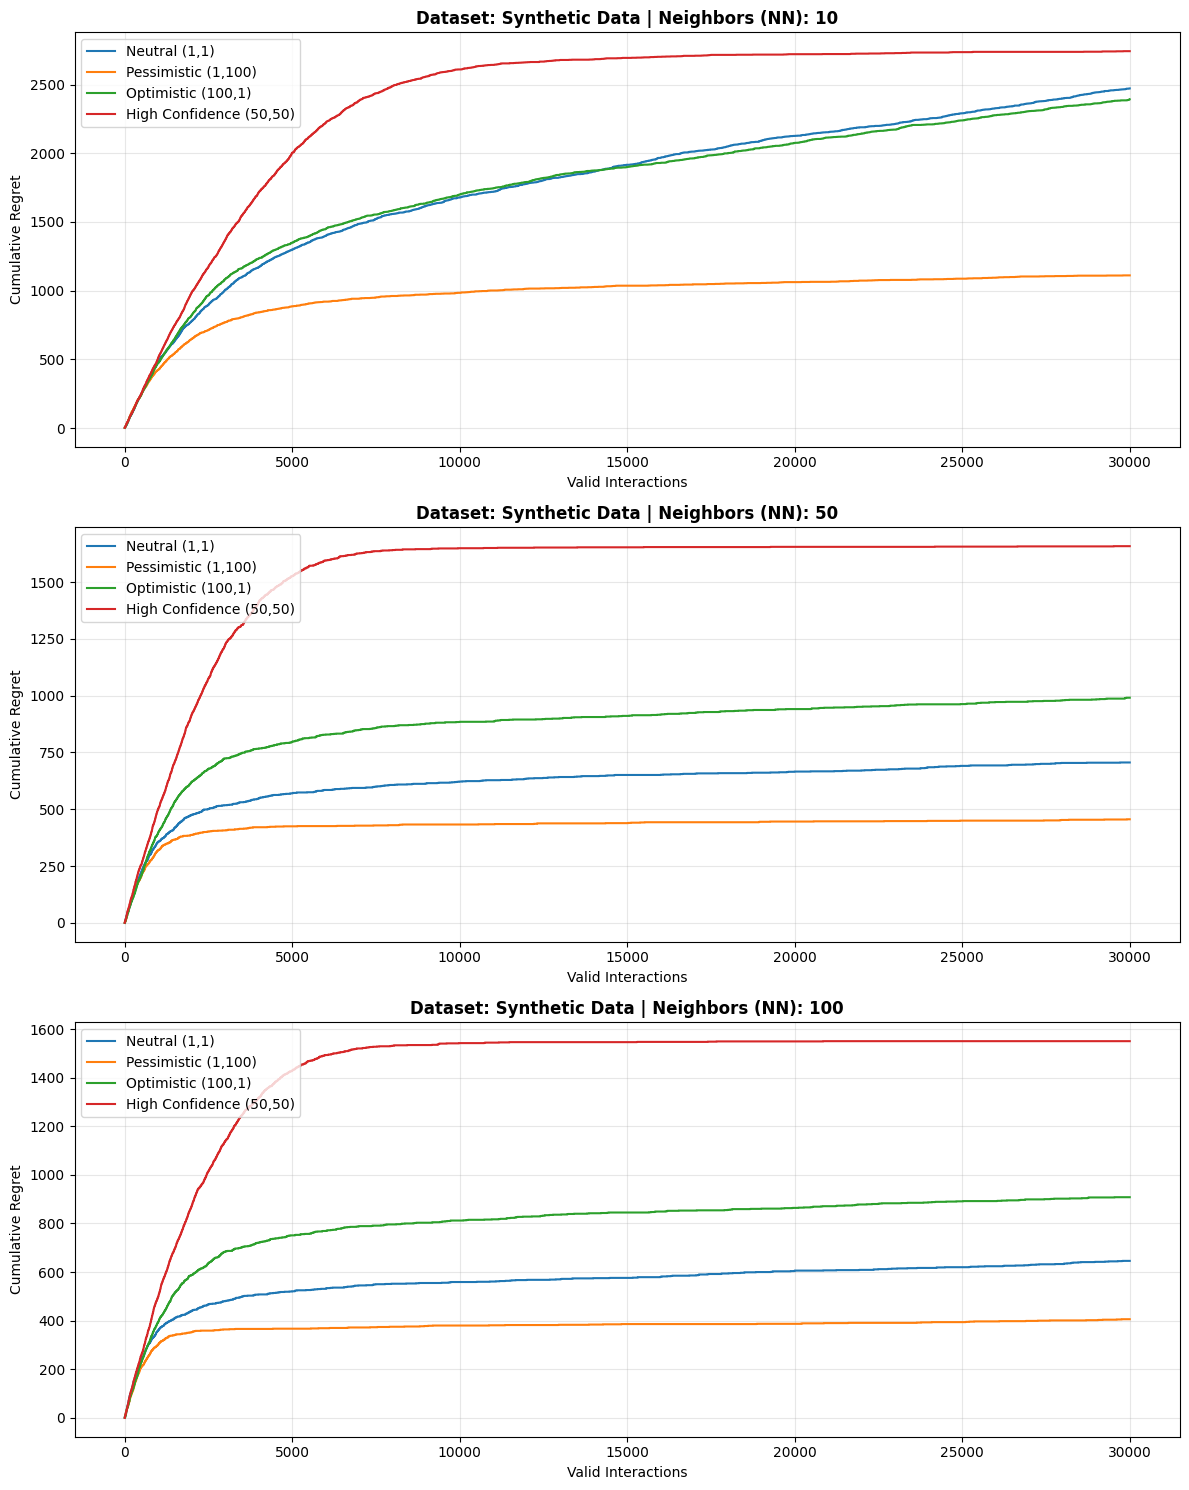


STARTING EXPERIMENT: MOVIELENS (REAL)
Target Interactions: 30000
K values to test: [10, 50]

  > Running simulations for K=10...
Starting simulation for 30000 valid interactions...
Simulation finished. Collected 30000 valid interactions.
Starting simulation for 30000 valid interactions...
Simulation finished. Collected 30000 valid interactions.
Starting simulation for 30000 valid interactions...
Simulation finished. Collected 30000 valid interactions.
Starting simulation for 30000 valid interactions...
Simulation finished. Collected 30000 valid interactions.

  > Running simulations for K=50...
Starting simulation for 30000 valid interactions...
Simulation finished. Collected 30000 valid interactions.
Starting simulation for 30000 valid interactions...
Simulation finished. Collected 30000 valid interactions.
Starting simulation for 30000 valid interactions...
Simulation finished. Collected 30000 valid interactions.
Starting simulation for 30000 valid interactions...
Simulation finishe

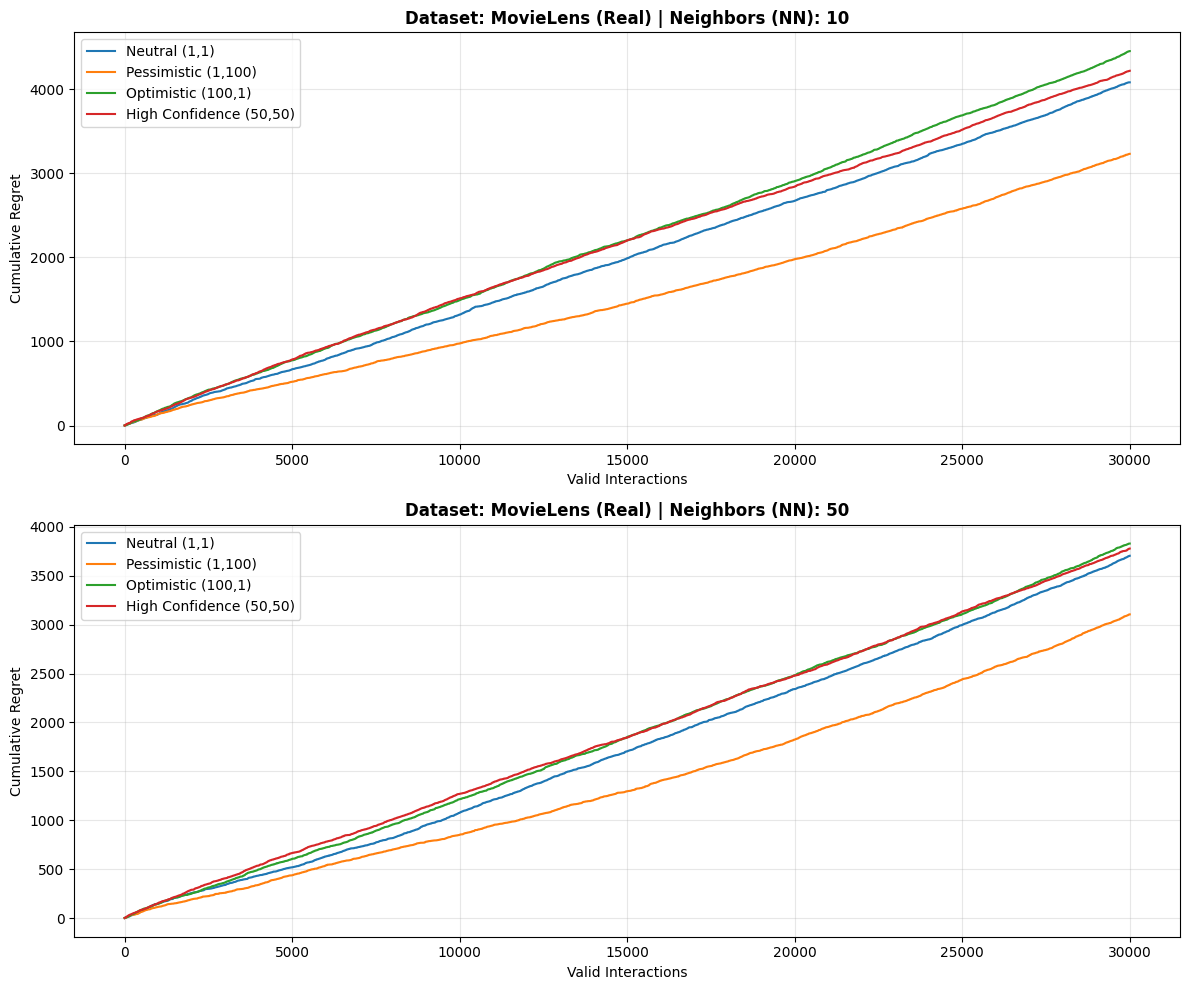


All experiments completed.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# 0. Helper Function: Regret Calculation
# ============================================================
def calculate_regret_metrics(recommendations, optimal_reward=1.0):
    # recommendations format: [user, item, rating, binary_reward]
    rewards = np.array([rec[3] for rec in recommendations]) 
    instant_regret = optimal_reward - rewards
    return np.cumsum(instant_regret)

# ============================================================
# 1. Experiment Configuration
# ============================================================

# A. Priors to Compare (Alpha, Beta, Label)
priors_to_test = [
    (1.0, 1.0, "Neutral (1,1)"),
    (1.0, 100.0, "Pessimistic (1,100)"),
    (100.0, 1.0, "Optimistic (100,1)"),
    (50.0, 50.0, "High Confidence (50,50)")
]

# B. Datasets Configuration
# format: "Name": { 'data': dataframe, 'n_sim': int, 'k_vals': list_of_int }
experiments_config = {
    "Synthetic Data": {
        "data": synthetic_ratings,       # Ensure this variable exists in your scope
        "n_sim": 30000,                  # Higher count for synthetic
        "k_vals": [10, 50, 100]          # K values to test
    },
    "MovieLens (Real)": {
        "data": ratings,                 # Ensure this variable exists in your scope
        "n_sim": 30000,                  # Lower count for real data (slower)
        "k_vals": [10, 50]               # K values to test
    }
}

# ============================================================
# 2. Main Loop Over Datasets
# ============================================================

for dataset_name, config in experiments_config.items():
    
    data_source = config["data"]
    n_interactions = config["n_sim"]
    k_values = config["k_vals"]
    
    print(f"\n{'='*60}")
    print(f"STARTING EXPERIMENT: {dataset_name.upper()}")
    print(f"Target Interactions: {n_interactions}")
    print(f"K values to test: {k_values}")
    print(f"{'='*60}")
    
    # Create one big figure for this Dataset
    n_plots = len(k_values)
    fig, axes = plt.subplots(n_plots, 1, figsize=(12, 5 * n_plots), sharex=False)
    
    # Handle case where there is only 1 K value (axes is not a list)
    if n_plots == 1:
        axes = [axes]
        
    # --- Loop over K values ---
    for ax, k in zip(axes, k_values):
        print(f"\n  > Running simulations for K={k}...")
        
        # --- Loop over Priors ---
        for alpha, beta, label in priors_to_test:
            
            # Initialize Bandit
            bandit = KNNBandit(
                k=k, 
                ratings=data_source, 
                alpha_prior=alpha, 
                beta_prior=beta
            )
            
            # Run Simulation
            # We add a small safety multiplier to max_attempts to ensure we get our data
            recs = bandit.simulate(n_interactions=n_interactions, max_attempts=n_interactions*500)
            
            # Calculate Regret
            cum_regret = calculate_regret_metrics(recs, optimal_reward=1.0)
            
            # Plot Curve
            ax.plot(cum_regret, linewidth=1.5, label=label)
            
        # Subplot Formatting
        title_text = f"Dataset: {dataset_name} | Neighbors (NN): {k}"
        ax.set_title(title_text, fontsize=12, fontweight='bold')
        ax.set_ylabel("Cumulative Regret")
        ax.set_xlabel("Valid Interactions")
        ax.grid(True, alpha=0.3)
        ax.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

print("\nAll experiments completed.")